In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
import tempfile
import numpy as np

from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf

import os

def read_data(bat_size):
    reader = tf.TFRecordReader()

    filename_queue = tf.train.string_input_producer(["test/TFRecord/test.tfrecords"])

    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
            serialized_example,
            features={
            'image_raw': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64)
        })
    labels = tf.cast(features['label'], tf.int32)
    images = tf.decode_raw(features['image_raw'], tf.int64)
    images = tf.reshape(images, shape=[48, 24, 1])
#     images = tf.split(images,3,2)[0]
#     images = tf.div(tf.cast(images, tf.float32), 255)
    # 采用shuffle_batch
    images_batch, labels_batch = tf.train.shuffle_batch([images, labels],
                                                            batch_size=bat_size,
                                                            num_threads=2,
                                                            capacity=500,
                                                            min_after_dequeue=450,
                                                            shapes=([48,24, 1],[])
                                                            )
       
        
    
    return images_batch, labels_batch


def conv2d(x, W):
    """conv2d returns a 2d convolution layer with full stride."""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')


def max_pool_2x2(x):
    """max_pool_2x2 downsamples a feature map by 2X."""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


def weight_variable(shape):
    """weight_variable generates a weight variable of a given shape."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    """bias_variable generates a bias variable of a given shape."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def deepnn(x):
     # input
    with tf.name_scope('reshape'):
        x_image = tf.reshape(x, [-1, 48, 24, 1])
  # First convolutional layer - maps one grayscale image to 32 feature maps.
    with tf.name_scope('conv1'):
        W_conv1 = weight_variable([5, 5, 1, 32])
        b_conv1 = bias_variable([32])
        h_conv1 = tf.nn.tanh(conv2d(x_image, W_conv1) + b_conv1)

  # Pooling layer - downsamples by 2X.
    with tf.name_scope('pool1'):
        h_pool1 = max_pool_2x2(h_conv1)
    # second convolutional layer
    with tf.name_scope("conv2"):
        W_conv2 = weight_variable([5,5,32,64])
        b_conv2 = bias_variable([64])
        h_conv2 = tf.nn.tanh(conv2d(h_pool1, W_conv2) + b_conv2)
    
    with tf.name_scope("pool2"):
        h_pool2 = max_pool_2x2(h_conv2)
    
    pool_size = tf.shape(h_pool2)
    reshape = tf.reshape(h_pool2, [pool_size[0], -1])
    
  # Fully connected layer 1 -- after 2 round of downsampling, our 28x28 image
    with tf.name_scope('fc1'):
        W_fc1 = weight_variable([9*3*64, 1024])
        b_fc1 = bias_variable([1024])

        h_fc1 = tf.nn.tanh(tf.matmul(reshape, W_fc1) + b_fc1)
    
  # Dropout - controls the complexity of the model, prevents co-adaptation of features.
    with tf.name_scope('dropout'):
        keep_prob = tf.placeholder(tf.float32)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
        
        
    # Fully connected layer 2    
    with tf.name_scope('fc2'):
        W_fc2 = weight_variable([1024, 34])
        b_fc2 = bias_variable([34])

        y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

    return y_conv, keep_prob



# Import data
images_batch, labels_batch = read_data(100)

# Create the model
x = tf.placeholder(tf.float32, [None, 48, 24, 1])

# Define loss and optimizer
y_ = tf.placeholder(tf.float32, [None, 34])

def onhot(lab):
    y_label = np.zeros([100,34])
    for i in range(100):
        y_label[i,lab[i]] = 1
    return y_label

# Build the graph for the deep net
y_conv, keep_prob = deepnn(x)


with tf.name_scope('loss'):
    cross_entropy =  tf.nn.softmax_cross_entropy_with_logits(labels=y_,
                                                        logits=y_conv)
    cross_entropy = tf.reduce_mean(cross_entropy)

with tf.name_scope('adam_optimizer'):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

ckpt_dir = "./ckpt_dir"
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
    
# saver
saver = tf.train.Saver()

recall_num = np.zeros([34])
label_num = np.zeros([34])
result_num = []
with tf.Session() as sess:
    # 初始化变量
    sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    # save
    ckpt = tf.train.get_checkpoint_state(ckpt_dir)
    if ckpt and ckpt.model_checkpoint_path:
        print(ckpt.model_checkpoint_path)
        saver.restore(sess, ckpt.model_checkpoint_path)
        
    # train
#     for epoch in range(14400):
#         img, lab = sess.run([images_batch, labels_batch])

#         labe = onhot(lab)

#         my_loss, _, accuracy_validation = sess.run([cross_entropy, train_step, accuracy], feed_dict={x: img, y_: labe, keep_prob: 0.5})
#         saver.save(sess,ckpt_dir + "/model.ckpt")
#         if epoch % 20 == 0:
#             print('epoch %d, loss is %g validation accuracy %g' % (
#                 epoch,
#                 float(my_loss),
#                 float(accuracy_validation)))
    score = 0
    
    for epoch in range(43):
        img, lab = sess.run([images_batch, labels_batch])

        labe = onhot(lab)

        yy, my_loss, _, accuracy_validation = sess.run([y_conv, cross_entropy, train_step, accuracy], feed_dict={x: img, y_: labe, keep_prob: 1.0})
        score += accuracy_validation
        for i in range(yy.shape[0]):
            if (np.argmax(yy[i])) == lab[i]:
                recall_num[np.argmax(yy[i])] += 1
            label_num[lab[i]] += 1
        if epoch % 20 == 0:
            
            print('epoch %d, loss is %g validation accuracy %g' % (
                epoch,
                float(my_loss),
                float(accuracy_validation)))
    for i in range(34):
        result = recall_num[i] / label_num[i]
        result_num.append(result)
    real_score = score * 100 / 4300
    print(real_score)
    print(result_num)
    coord.request_stop()
    coord.join(threads)

./ckpt_dir/model.ckpt
INFO:tensorflow:Restoring parameters from ./ckpt_dir/model.ckpt
epoch 0, loss is 2.17278 validation accuracy 0.9
epoch 20, loss is 0.224741 validation accuracy 0.95
epoch 40, loss is 0.091771 validation accuracy 0.97
0.934418604818
[0.87704918032786883, 0.96825396825396826, 0.99315068493150682, 0.9921875, 0.95081967213114749, 0.965034965034965, 0.9928057553956835, 0.99212598425196852, 0.93150684931506844, 0.97872340425531912, 0.92567567567567566, 0.87755102040816324, 0.87654320987654322, 0.82857142857142863, 0.95348837209302328, 0.80952380952380953, 0.6428571428571429, 0.95302013422818788, 0.88749999999999996, 0.8529411764705882, 0.96103896103896103, 0.98750000000000004, 0.91044776119402981, 0.90769230769230769, 0.98275862068965514, 0.88405797101449279, 0.839622641509434, 0.92708333333333337, 0.77142857142857146, 0.78260869565217395, 0.95061728395061729, 0.99395161290322576, 0.9747474747474747, 0.94117647058823528]


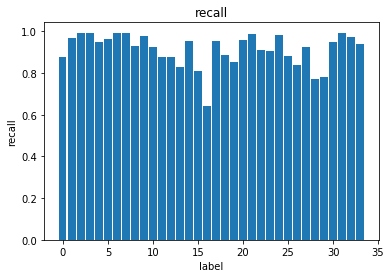

In [2]:
import matplotlib.pyplot as plt

num = result_num

plt.bar(range(len(num)), num)

plt.xlabel("label")
plt.ylabel("recall")
plt.title("recall")
#plt.legend()
plt.show()